# anli_r3

In [1]:
import pickle

# 打开包含数据结构的文件
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/anli_r3_train_bge_embedding.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    embedding_train = pickle.load(f)
import numpy as np
for i in range(len(embedding_train)):
    embedding_train[i]['embedding'] = np.array(embedding_train[i]['embedding'])

train_embedding_matrix = []
for i in range(len(embedding_train)):
    train_embedding_matrix.append(embedding_train[i]['embedding'])

train_embedding_matrix = np.array(train_embedding_matrix)



In [6]:
train_embedding_matrix[0].shape

(1024,)

In [3]:
# alpaca_evol: len(embedding_train) = 70000
# alpaca: len(embedding_train) = 51760
train_embedding_matrix[0][0]

-0.005349006038159132

In [4]:
def split_simliarity_matrix(train_embedding_matrix, split_size):
    block_num, last_matrix_size = np.divmod(train_embedding_matrix.shape[0], split_size)
    split_matrix_list = []
    for i in range(block_num):
        tmp = np.matmul(train_embedding_matrix \
                        ,train_embedding_matrix[ int(i*split_size) :int((i+1)*split_size) ].T)
        split_matrix_list.append(tmp)
    tmp = np.matmul(train_embedding_matrix \
                        ,train_embedding_matrix[ int(block_num*split_size) :].T) 
    split_matrix_list.append(tmp)
    return split_matrix_list


def return_inital_point(split_sim_matrix,split_size):
    idx = 0
    min_value = np.inf
    for i in range(len(split_sim_matrix)):
        tmp = np.min(split_sim_matrix[i])
        if tmp < min_value:
            min_value = tmp
            idx = i
    target_matrix = split_sim_matrix[idx]
    r,c = np.divmod(np.argmin(target_matrix),split_size)
    return r

def get_similar(query_id, split_sim_matrix, pop_point_list=[]):
    # 提前创建布尔掩码 
    mask = np.ones(sum(matrix.shape[1] for matrix in split_sim_matrix), dtype=bool)
    mask[pop_point_list] = False
    
    # 拼接向量，并直接使用布尔索引
    sim_vector = np.concatenate(tuple(matrix[query_id] for matrix in split_sim_matrix) , axis=0)
    
    # 使用布尔索引来生成 key 和 value
    key = np.arange(len(sim_vector))[mask]
    value = sim_vector[mask]
    
    # 创建字典
    pair = dict(zip(key, value))
    return pair

def kcenter_greedy(split_sim_matrix, data = embedding_train, k=500, seed = 144, inital_point_id = None, ):
    if inital_point_id is None:
    # inital center data
        idxs = list(range(len(data)))
        np.random.seed(seed)
        new_centers_id = np.random.choice(idxs)
        # 中心点的集合
    else:
        new_centers_id = inital_point_id
    centers_list = [new_centers_id] 
    distence_list = []

    old_distence_to_center = get_similar(new_centers_id, split_sim_matrix, pop_point_list=centers_list)
    
    # while len(centers_list) < k:
    for i in range(k-1):
        # 最低相似度的点
        new_centers_id = min(old_distence_to_center, key=old_distence_to_center.get)
        distence_list.append(old_distence_to_center[new_centers_id])
        print(f'{i}, {old_distence_to_center[new_centers_id]}')
        # if(old_distence_to_center[new_centers_id]>=0.5):
        #     break
        old_distence_to_center.pop(new_centers_id)
        
        centers_list.append(new_centers_id)
        new_distence_to_center = get_similar(new_centers_id, split_sim_matrix, pop_point_list=centers_list)
        # 更新其他点离中心点的距离 
        old_distence_to_center = {key: max(new_distence_to_center[key], old_distence_to_center[key]) for key in new_distence_to_center}
    print('finish')
    return centers_list,distence_list


def main(train_embedding_matrix, split_size):
    split_sim_matrix = split_simliarity_matrix(train_embedding_matrix=train_embedding_matrix,split_size=split_size) 
    print('finish_split')
    intial_point = return_inital_point(split_sim_matrix,split_size)
    print(f'finish_find_point{intial_point}')
    k_size = train_embedding_matrix.shape[0]
    kcenter_greedy(split_sim_matrix,
                   data = embedding_train,
                   k=2,
                   seed = 144,
                   inital_point_id = intial_point)

In [5]:
split_size = 35000
split_sim_matrix = split_simliarity_matrix(train_embedding_matrix=train_embedding_matrix,split_size=split_size) 
print('finish_split')
intial_point = return_inital_point(split_sim_matrix,split_size)
print(f'finish_find_point{intial_point}')

finish_split
finish_find_point40701


In [7]:
k_size = train_embedding_matrix.shape[0]
res = kcenter_greedy(split_sim_matrix,
                   data = embedding_train,
                   k = k_size,
                #    seed = 1024,
                   inital_point_id = intial_point
                   )
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/anli_r3_bge_kcg.pkl', 'wb') as f:
    pickle.dump(res, f)

# import matplotlib.pyplot as plt
# plt.figure()
# x = plt.hist(res[1],bins=500)

0, 0.12263664069573474
1, 0.24102565013360214
2, 0.26173951870634454
3, 0.2894795888126539
4, 0.2991055536560167
5, 0.3003814797159236
6, 0.31233902839069866
7, 0.3228218634518429
8, 0.3297867504880434
9, 0.3357967610618493
10, 0.3359368866290648
11, 0.34148859793545794
12, 0.3486926251599154
13, 0.34965617489667233
14, 0.3511543900783903
15, 0.3553332354798554
16, 0.35761321746993274
17, 0.3584858247539167
18, 0.36239476012886457
19, 0.36326905621323147
20, 0.3653662846349421
21, 0.36757856387062066
22, 0.3676722673427337
23, 0.36899688834977634
24, 0.3712228581267306
25, 0.3739227554749063
26, 0.3771271355579672
27, 0.3802458061446564
28, 0.38184372402182953
29, 0.382504110201222
30, 0.3838933074559999
31, 0.3852010371542456
32, 0.3858610053992898
33, 0.38695025787733767
34, 0.3876030573009046
35, 0.3903737031655539
36, 0.3904344044158863
37, 0.3915882784173116
38, 0.39247903804716133
39, 0.3941068052346239
40, 0.3951846205355218
41, 0.3957991947906027
42, 0.39753333180503636
43, 0.4

In [5]:
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test_data_selection/output/anli_r3_noise_5e-1_kcg.pkl', 'wb') as f:
    pickle.dump(res, f)

# load data

In [37]:
import pickle
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/alpacaAndEvol.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    centers = pickle.load(f)

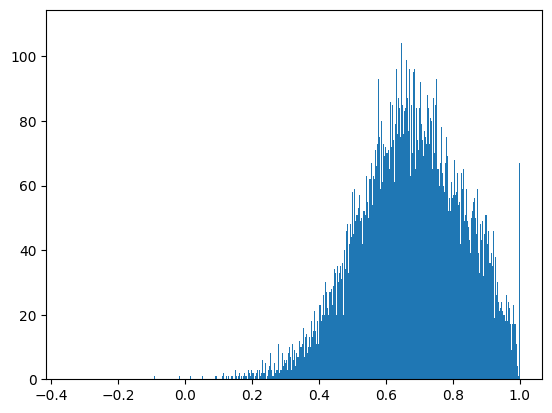

In [4]:
import matplotlib.pyplot as plt
plt.figure()
x = plt.hist(centers[1],bins=5000)

In [21]:
alpaca_evol = []
alpaca_clean = []

for i,idx in zip(centers[0], list(range(len(centers[1]))) ):
    if i < 70000:
        alpaca_evol.append(centers[1][idx])
    else:
        alpaca_clean.append(centers[1][idx])

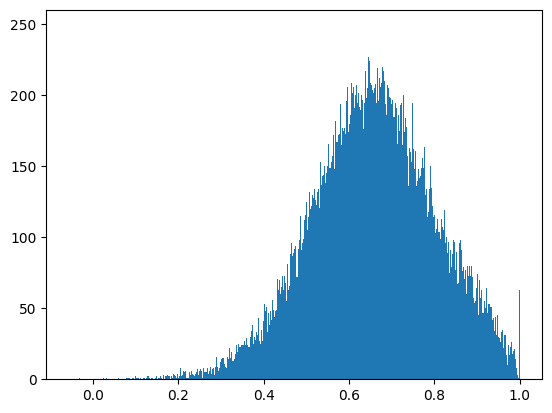

In [25]:
plt.figure()
x = plt.hist(alpaca_evol,bins=1000)

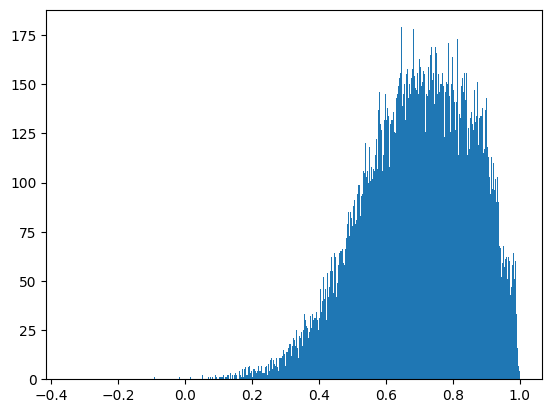

In [26]:
plt.figure()
x = plt.hist(alpaca_clean,bins=1000)

# load alpaca and evol

In [1]:
alpaca_clean_data_path =  '/data/home/chenpz/git_clone_project/nlpData/alpaca/alpaca_data_cleaned.json'
alpaca_evol_data_path = '/data/home/chenpz/git_clone_project/nlpData/alpaca_evol/alpaca_evol_instruct_70k.json'


from datasets import load_dataset
import pickle

alpaca_clean_data =  load_dataset('json',data_files=alpaca_clean_data_path)
alpaca_evol_data = load_dataset('json',data_files=alpaca_evol_data_path)

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/alpacaAndEvol.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    centers = pickle.load(f)

/data/home/chenpz/.conda/envs/llama_factory/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## random sampling

In [11]:
import random
kcenter5000 = centers[0][:-5000]
random.shuffle(kcenter5000)
train_item = kcenter5000[:5000]
vaild_tiem = kcenter5000[5000:]


res = []
size = len(alpaca_evol_data['train'])
for idx in train_item:
    if idx < size:
        item = alpaca_evol_data['train'][int(idx)]
        item['input'] = ''
        res.append(item)
    else:
        res.append(alpaca_clean_data['train'][int(idx-size)])
import json
with open('/data/home/chenpz/git_clone_project/nlpData/mix_data_of_alpaca/random.json','w') as f:
    json.dump(res,f)

res = []
size = len(alpaca_evol_data['train'])
for idx in vaild_tiem:
    if idx < size:
        item = alpaca_evol_data['train'][int(idx)]
        item['input'] = ''
        res.append(item)
    else:
        res.append(alpaca_clean_data['train'][int(idx-size)])

import json
with open('/data/home/chenpz/git_clone_project/nlpData/mix_data_of_alpaca/vaild_for_random.json','w') as f:
    json.dump(res,f)

## FFP_Kcenter_sampling

In [2]:
len(alpaca_evol_data['train'])

70000

In [2]:
kcenter1000 = centers[0]
res = []
size = len(alpaca_evol_data['train'])
for idx in kcenter1000:
    if idx < size:
        item = alpaca_evol_data['train'][int(idx)]
        item['input'] = ''
        res.append(item)
    else:
        res.append(alpaca_clean_data['train'][int(idx-size)])

In [4]:
import json
with open('/data/home/chenpz/git_clone_project/nlpData/mix_data_of_alpaca/FFP_all.json','w') as f:
    json.dump(res,f)

In [3]:
kcenter_meidan_data = centers[0][5000:-5000]
res = []
size = len(alpaca_evol_data['train'])
for idx in kcenter_meidan_data:
    if idx < size:
        item = alpaca_evol_data['train'][int(idx)]
        item['input'] = ''
        res.append(item)
    else:
        res.append(alpaca_clean_data['train'][int(idx-size)])

In [4]:
import json
with open('/data/home/chenpz/git_clone_project/nlpData/mix_data_of_alpaca/vaild_for_5000.json','w') as f:
    json.dump(res,f)

# For all

In [1]:
import pickle

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/anli_can_we_infer_r3_train.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    embedding_train = pickle.load(f)

# with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/alpaca_qa.pkl', 'rb') as f:
#     # 使用 pickle.load() 函数加载数据结构
#     embedding_train += pickle.load(f)

In [2]:
import numpy as np
for i in range(len(embedding_train)):
    embedding_train[i]['embedding'] = np.array(embedding_train[i]['embedding'])

train_embedding_matrix = []
for i in range(len(embedding_train)):
    train_embedding_matrix.append(embedding_train[i]['embedding'])
train_embedding_matrix = np.array(train_embedding_matrix)

In [7]:
def split_simliarity_matrix(train_embedding_matrix, split_size):
    block_num, last_matrix_size = np.divmod(train_embedding_matrix.shape[0], split_size)
    split_matrix_list = []
    for i in range(block_num):
        tmp = np.matmul(train_embedding_matrix \
                        ,train_embedding_matrix[ int(i*split_size) :int((i+1)*split_size) ].T)
        split_matrix_list.append(tmp)
    tmp = np.matmul(train_embedding_matrix \
                        ,train_embedding_matrix[ int(block_num*split_size) :].T) 
    split_matrix_list.append(tmp)
    return split_matrix_list
import numpy as np


def return_inital_point(split_sim_matrix,split_size):
    idx = 0
    min_value = np.inf
    for i in range(len(split_sim_matrix)):
        tmp = np.min(split_sim_matrix[i])
        if tmp < min_value:
            min_value = tmp
            idx = i
    target_matrix = split_sim_matrix[idx]
    r,c = np.divmod(np.argmin(target_matrix),split_size)
    return r

def get_similar(query_id, split_sim_matrix, pop_point_list=[]):
    # 提前创建布尔掩码 
    mask = np.ones(sum(matrix.shape[1] for matrix in split_sim_matrix), dtype=bool)
    mask[pop_point_list] = False
    
    # 拼接向量，并直接使用布尔索引
    sim_vector = np.concatenate(tuple(matrix[query_id] for matrix in split_sim_matrix) , axis=0)
    
    # 使用布尔索引来生成 key 和 value
    key = np.arange(len(sim_vector))[mask]
    value = sim_vector[mask]
    
    # 创建字典
    pair = dict(zip(key, value))
    return pair

def kcenter_greedy(split_sim_matrix, k=500, seed = 144, inital_point_id = None, ):
    if inital_point_id is None:
    # inital center data
        idxs = list(range(split_sim_matrix[0].shape[0]))
        np.random.seed(seed)
        new_centers_id = np.random.choice(idxs)
        # 中心点的集合
    else:
        new_centers_id = inital_point_id
    centers_list = [new_centers_id] 
    distence_list = []

    old_distence_to_center = get_similar(new_centers_id, split_sim_matrix, pop_point_list=centers_list)
    
    # while len(centers_list) < k:
    for i in range(k-1):
        # 最低相似度的点
        new_centers_id = min(old_distence_to_center, key=old_distence_to_center.get)
        distence_list.append(old_distence_to_center[new_centers_id])
        # print(f'{i}, {old_distence_to_center[new_centers_id]}')
        # if(old_distence_to_center[new_centers_id]>=0.5):
        #     break
        old_distence_to_center.pop(new_centers_id)
        
        centers_list.append(new_centers_id)
        new_distence_to_center = get_similar(new_centers_id, split_sim_matrix, pop_point_list=centers_list)
        # 更新其他点离中心点的距离 
        old_distence_to_center = {key: max(new_distence_to_center[key], old_distence_to_center[key]) for key in new_distence_to_center}
    # print('finish')
    return centers_list,distence_list

def farthest_point_sampling(split_sim_matrix, data = embedding_train, k=500, seed = 144, inital_point_id = None, ):
    if inital_point_id is None:
    # inital center data
        idxs = list(range(len(data)))
        np.random.seed(seed)
        new_centers_id = np.random.choice(idxs)
    # 中心点的集合
    else:
        new_centers_id = inital_point_id
    centers_list = [new_centers_id] 
    distence_list = []

    distence_to_center = get_similar(new_centers_id, split_sim_matrix, pop_point_list=centers_list)
    for i in range(k-1):
        # 最低相似度的点
        new_centers_id = min(distence_to_center, key=distence_to_center.get)
        distence_list.append(distence_to_center[new_centers_id])
        print(f'{i}, {distence_to_center[new_centers_id]}')
        
        centers_list.append(new_centers_id)
        distence_to_center = get_similar(new_centers_id, split_sim_matrix, pop_point_list=centers_list)

    print('finish')
    return centers_list,distence_list


def main(train_embedding_matrix, split_size):
    split_sim_matrix = split_simliarity_matrix(train_embedding_matrix=train_embedding_matrix,split_size=split_size) 
    print('finish_split')
    intial_point = return_inital_point(split_sim_matrix,split_size)
    print(f'finish_find_point{intial_point}')
    k_size = train_embedding_matrix.shape[0]
    kcenter_greedy(split_sim_matrix,
                   data = embedding_train,
                   k=k_size,
                   seed = 144,
                   inital_point_id = intial_point)

In [4]:
import random

sort_res = []
k_size = train_embedding_matrix.shape[0]
sim_times = 100
sampling_size = 20000
for i in range(sim_times):

    random_points = random.sample(range(k_size), sampling_size)
    sample_embedding = train_embedding_matrix[random_points]


    split_size = 30000
    mask_split_sim_matrix = split_simliarity_matrix(train_embedding_matrix=sample_embedding, split_size=split_size) 
    print(f'finish{i}')
    res = kcenter_greedy(mask_split_sim_matrix,
                    k=len(random_points),
                    seed = 1,
                    # inital_point_id = intial_point
                    )[0]

    index_dict = {value: idx for value, idx in enumerate(random_points)}
    sort_idx = [index_dict[value] for value in res]
    sort_res.append(sort_idx)

finish0
finish1
finish2
finish3
finish4
finish5
finish6
finish7
finish8
finish9
finish10
finish11
finish12
finish13
finish14
finish15
finish16
finish17
finish18
finish19
finish20
finish21
finish22
finish23
finish24
finish25
finish26
finish27
finish28
finish29
finish30
finish31
finish32
finish33
finish34
finish35
finish36
finish37
finish38
finish39
finish40
finish41
finish42
finish43
finish44
finish45
finish46
finish47
finish48
finish49
finish50
finish51
finish52
finish53
finish54
finish55
finish56
finish57
finish58
finish59
finish60
finish61
finish62
finish63
finish64
finish65
finish66
finish67
finish68
finish69
finish70
finish71
finish72
finish73
finish74
finish75
finish76
finish77
finish78
finish79
finish80
finish81
finish82
finish83
finish84
finish85
finish86
finish87
finish88
finish89
finish90
finish91
finish92
finish93
finish94
finish95
finish96
finish97
finish98
finish99


In [6]:
split_size = 30000
split_sim_matrix = split_simliarity_matrix(train_embedding_matrix=train_embedding_matrix,split_size=split_size) 
print('finish_split')
# intial_point = return_inital_point(split_sim_matrix,split_size)
# print(f'finish_find_point{intial_point}')
# k_size = train_embedding_matrix.shape[0]
# res = farthest_point_sampling(split_sim_matrix,
#                 k=k_size,
#                 seed = 1,
#                 # inital_point_id = intial_point
#                 )

finish_split


In [3]:
import pickle
import json
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/kcenters_rank_fromFarPoint.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    rank_data = pickle.load(f)

In [11]:
last_data = rank_data[-5000:]
first_data = rank_data[:5000]

train_embedding_matrix[last_data].shape
split_size = 30000
last_data_train_embedding_matrix = train_embedding_matrix[last_data]
last_data_split_sim_matrix = split_simliarity_matrix(train_embedding_matrix=last_data_train_embedding_matrix,split_size=split_size)[0]

In [18]:
# np.min(last_data_split_sim_matrix), np.argmax(last_data_split_sim_matrix)
r,c = np.divmod(np.argmin(last_data_split_sim_matrix),5000)
r,c

(1977, 3169)

In [19]:
last_data_split_sim_matrix[1977, 3169]

-0.26575916714116304

In [5]:
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/squad_v2_fps_rank.pkl', 'wb') as f:
    pickle.dump(res , f)

# mix alpaca sampling 10000, 100 times

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/test_loss_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

In [2]:
import pickle

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/alpacaAndEvol.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    res1 = pickle.load(f)

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/aplaca_mix_20000samping_kcg_rank_101times.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    res2 = pickle.load(f)

with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/aplaca_mix_20000samping_kcg_rank_100times.pkl', 'rb') as f:
    # 使用 pickle.load() 函数加载数据结构
    res2 += pickle.load(f)

index_dict = {value: idx for idx, value in enumerate(res1[0])}

# 2. 按照 res2 的顺序重新排列 y

loss_list = []
for i in range(len(res2)):
    print(i)
    loss = [y[index_dict[value]] for value in res2[i]]
    loss_list.append(loss)
loss_list  = np.array(loss_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


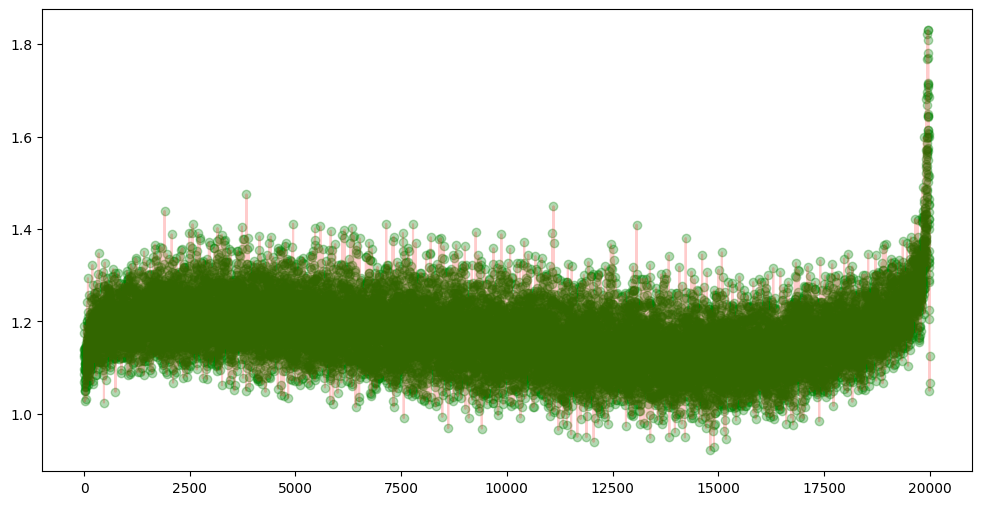

In [ ]:
loss = np.mean(loss_list, axis=0)
plt.figure(figsize=(12,6))
plt.scatter(range(len(loss)), loss, alpha= 0.3, c = 'g')
plt.plot(range(len(loss)), loss, alpha= 0.2, c = 'r')

In [8]:
print(f"dataset: mixed alpaca data, 数据量为：{len(loss)}")
chunk_sizes = [1, 10,50, 100]
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(loss), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = loss[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 分割后的数据
    x_corr = np.array(new_idx[:-1])
    y_corr = np.array(averages)

    # 分割位点比例
    ratio_corr = 0.6
    range_corr = range(int( ratio_corr * len(x_corr) ), len(x_corr))

    # 使用 numpy 计算皮尔逊相关系数
    # correlation_matrix = np.corrcoef(x_corr[range_corr], y_corr[range_corr])
    # correlation_coefficient = correlation_matrix[0, 1]

    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(x_corr[range_corr], y_corr[range_corr])

    print(f"chunk_sizes大小为: {n}, 选取后{ratio_corr * 100}%的数据, spearman_corr: {spearman_corr}")

dataset: mixed alpaca data, 数据量为：20000
chunk_sizes大小为: 1, 选取后60.0%的数据, spearman_corr: 0.4320926463530102
chunk_sizes大小为: 10, 选取后60.0%的数据, spearman_corr: 0.6589787796543431
chunk_sizes大小为: 50, 选取后60.0%的数据, spearman_corr: 0.7118803468885504
chunk_sizes大小为: 100, 选取后60.0%的数据, spearman_corr: 0.7100328176277543


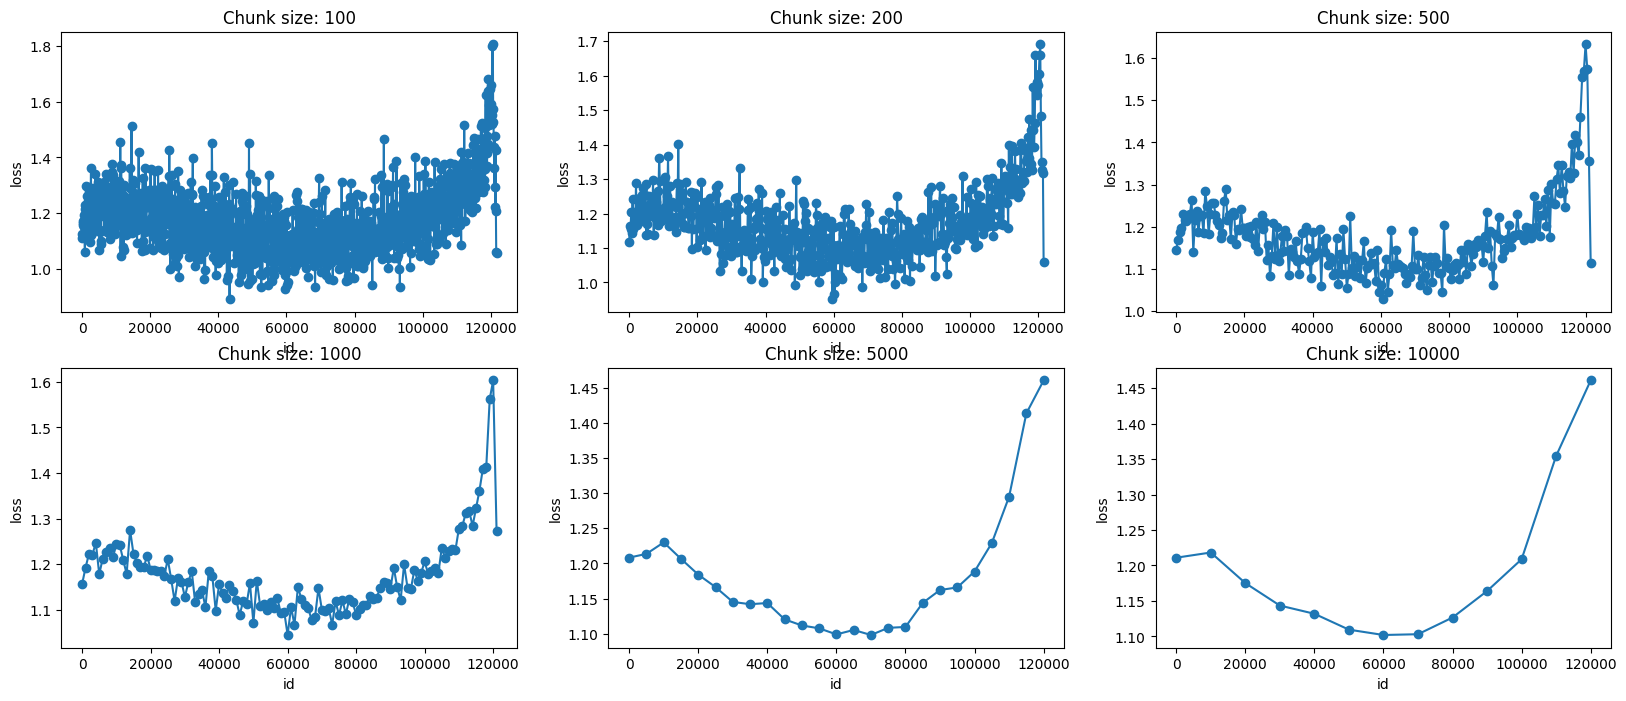

In [11]:
chunk_sizes = [100, 200, 500, 1000, 5000,10000]

# 创建一个2x2的subplot布局
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# 遍历chunk_sizes并绘制图像
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(y), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = y[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 将图像绘制到相应的subplot位置
    ax = axs[idx // 3, idx % 3]  # 定位subplot的位置
    ax.plot(new_idx[:-1], averages)
    ax.scatter(new_idx[:-1], averages)
    ax.set_xlabel('id')
    ax.set_ylabel('loss')
    ax.set_title(f'Chunk size: {n}')


# dolly 71 times

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/dolly_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

In [14]:
import pickle
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/dolly_qa_ffp_rank.pkl', 'rb') as f:
    res1 = pickle.load(f)
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/dolly_kcg_rank_71times.pkl', 'rb') as f:
    res100 = pickle.load(f)

index_dict = {value: idx for idx, value in enumerate(res1[0])}

# 2. 按照 res2 的顺序重新排列 y
loss_list = []
for res2 in res100:
    loss_list.append( [y[index_dict[value]] for value in res2] )

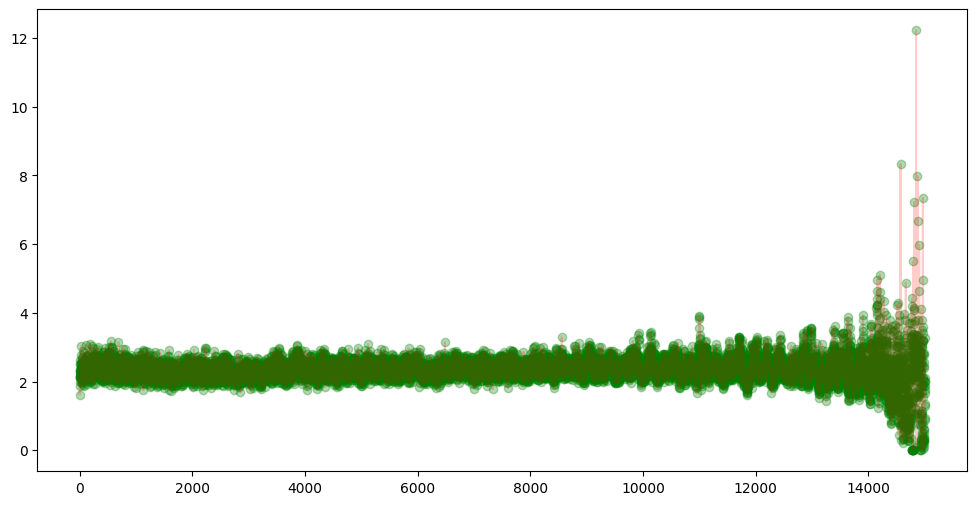

In [15]:
loss = np.mean(loss_list, axis=0)
plt.figure(figsize=(12,6))
plt.scatter(range(len(loss)), loss, alpha= 0.3, c = 'g')
plt.plot(range(len(loss)), loss, alpha= 0.2, c = 'r')

# super_glue_wic_loss_FFP_all 100times

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import json

x = []
y = []
# 从 JSON 文件读取数据
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/super_glue_wic_loss_FFP_all.jsonl', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        line = line.strip().replace("'", '"')
        data = json.loads(line)
        x.append(data['id'])
        y.append(data['loss'])

In [17]:
import pickle
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/super_glue_wic_ffp_rank.pkl', 'rb') as f:
    res1 = pickle.load(f)
with open('/data/home/chenpz/git_clone_project/jupyter_notebook_test/output/super_glue_wic_kcg_rank_100times.pkl', 'rb') as f:
    res100 = pickle.load(f)

index_dict = {value: idx for idx, value in enumerate(res1[0])}

# 2. 按照 res2 的顺序重新排列 y
loss_list = []
for res2 in res100:
    loss_list.append( [y[index_dict[value]] for value in res2] )

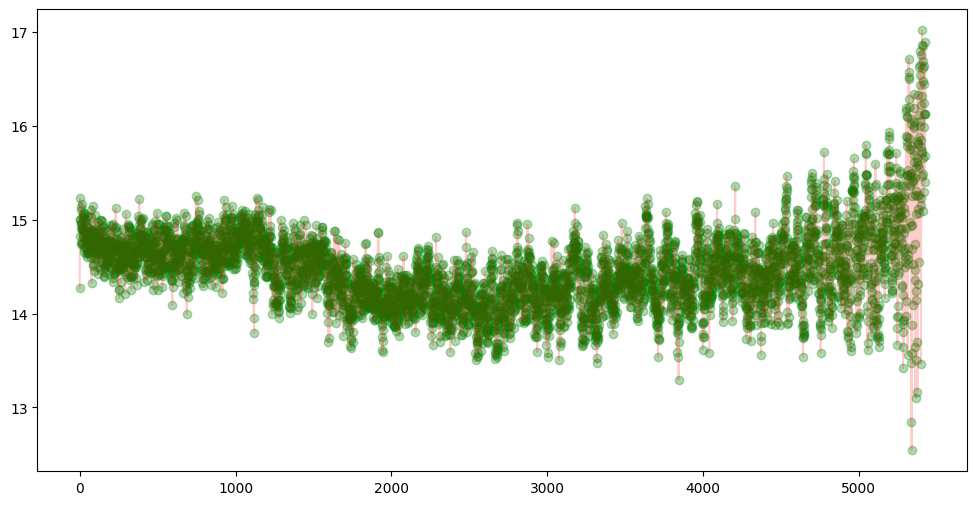

In [18]:
loss = np.mean(loss_list, axis=0)
plt.figure(figsize=(12,6))
plt.scatter(range(len(loss)), loss, alpha= 0.3, c = 'g')
plt.plot(range(len(loss)), loss, alpha= 0.2, c = 'r')

In [19]:
print(f"dataset: mixed alpaca data, 数据量为：{len(loss)}")
chunk_sizes = [1, 10,50, 100]
for idx, n in enumerate(chunk_sizes):
    averages = []
    new_idx = list(range(0, len(loss), n))
    new_idx.append(len(y))  # Ensure to include the last chunk

    for i in range(len(new_idx) - 1):
        chunk = loss[new_idx[i]:new_idx[i + 1]]
        avg = np.mean(chunk)
        averages.append(avg)

    # 分割后的数据
    x_corr = np.array(new_idx[:-1])
    y_corr = np.array(averages)

    # 分割位点比例
    ratio_corr = 0.6
    range_corr = range(int( ratio_corr * len(x_corr) ), len(x_corr))

    # 使用 numpy 计算皮尔逊相关系数
    # correlation_matrix = np.corrcoef(x_corr[range_corr], y_corr[range_corr])
    # correlation_coefficient = correlation_matrix[0, 1]

    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(x_corr[range_corr], y_corr[range_corr])

    print(f"chunk_sizes大小为: {n}, 选取后{ratio_corr * 100}%的数据, spearman_corr: {spearman_corr}")

dataset: mixed alpaca data, 数据量为：5428
chunk_sizes大小为: 1, 选取后60.0%的数据, spearman_corr: 0.42630001223247893
chunk_sizes大小为: 10, 选取后60.0%的数据, spearman_corr: 0.5288987061214396
chunk_sizes大小为: 50, 选取后60.0%的数据, spearman_corr: 0.7405214940098661
chunk_sizes大小为: 100, 选取后60.0%的数据, spearman_corr: 0.8825522303783175
